
# Model-Based Curation Tutorial

This notebook provides a detailed, step-by-step guide on how to use a machine learning classifier for curating spike-sorted output. We will download a pre-trained model and apply it to label spike sorted data using Spikeinterface. Here we sue sortting_analyzer. The process begins by importing the necessary packages.



In [8]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import spikeinterface.core as si
import spikeinterface.widgets as sw

In [9]:
# In the cell below If you're getting an import error, try adding the root path manually in your notebook:

## how to add root path manually is shown below 
# import sys
# sys.path.append(r"C:\Users\jain\Documents\GitHub\UnitRefine") # path to UnitRefine in locally directory

In [21]:
from UnitRefine.scripts.model_based_curation import load_model, auto_label_units

## import from Spikeinterface package
#from spikeinterface.curation import load_model, auto_label_units

## Download a pretrained model

Let's download a pretrained model from [Hugging Face](https://huggingface.co/) (HF). The
``load_model`` function allows us to download directly from HF, or use a model in a local
folder. The function downloads the model and saves it in a temporary folder and returns a
model and some metadata about the model.



In [11]:
model, model_info = load_model(
    repo_id = "SpikeInterface/toy_tetrode_model",
    trusted = ['numpy.dtype']
)

This model was trained on artifically generated tetrode data. The model object has a nice html
representation, which will appear if you're using a Jupyter notebook.



In [12]:
model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        min_samples_leaf=2, n_estimators=125,
                                        random_state=1782856102))])

The model object (an sklearn Pipeline) contains information about which metrics
were used to compute the model. We can access it from the model (or from the model_info)



In [13]:
print(model.feature_names_in_)

['amplitude_cutoff' 'amplitude_cv_median' 'amplitude_cv_range'
 'amplitude_median' 'drift_ptp' 'drift_std' 'drift_mad' 'firing_range'
 'firing_rate' 'isi_violations_ratio' 'isi_violations_count' 'num_spikes'
 'presence_ratio' 'rp_contamination' 'rp_violations' 'sd_ratio'
 'sliding_rp_violation' 'snr' 'sync_spike_2' 'sync_spike_4' 'sync_spike_8'
 'd_prime' 'isolation_distance' 'l_ratio' 'silhouette' 'nn_hit_rate'
 'nn_miss_rate' 'half_width' 'num_negative_peaks' 'num_positive_peaks'
 'peak_to_valley' 'peak_trough_ratio' 'recovery_slope'
 'repolarization_slope']


Hence, to use this model we need to create a ``sorting_analyzer`` with all these metrics computed.
We'll do this by generating a recording and sorting, creating a sorting analyzer and computing a
bunch of extensions. Follow these links for more info on [recordings](https://spikeinterface.readthedocs.io/en/latest/modules/extractors.html), [sortings](https://spikeinterface.readthedocs.io/en/latest/modules/sorters.html), [sorting analyzers](https://spikeinterface.readthedocs.io/en/latest/tutorials/core/plot_4_sorting_analyzer.html#sphx-glr-tutorials-core-plot-4-sorting-analyzer-py)
and [extensions](https://spikeinterface.readthedocs.io/en/latest/modules/postprocessing.html).



In [14]:
recording, sorting = si.generate_ground_truth_recording(num_channels=4, seed=4, num_units=10)
sorting_analyzer = si.create_sorting_analyzer(sorting=sorting, recording=recording)
sorting_analyzer.compute(['noise_levels','random_spikes','waveforms','templates','spike_locations','spike_amplitudes','correlograms','principal_components','quality_metrics','template_metrics'])

estimate_sparsity:   0%|          | 0/10 [00:00<?, ?it/s]

noise_level:   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms:   0%|          | 0/10 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/10 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/10 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes:   0%|          | 0/10 [00:00<?, ?it/s]

noise_level:   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/10 [00:00<?, ?it/s]

This sorting_analyzer now contains the required quality metrics and template metrics.
We can check that this is true by accessing the extension data.



In [15]:
all_metric_names = list(sorting_analyzer.get_extension('quality_metrics').get_data().keys()) + list(sorting_analyzer.get_extension('template_metrics').get_data().keys())
print(np.all(sorted(all_metric_names) == sorted(model.feature_names_in_)))

True


Great! We can now use the model to predict labels. You can either pass a HuggingFace repo, or a
local folder containing the model file and the ``model_info.json`` file. Here, we'll pass
a repo. The function returns a dictionary containing a label and a confidence for each unit
contained in the ``sorting_analyzer``.



In [16]:
labels = auto_label_units(
    sorting_analyzer = sorting_analyzer,
    repo_id = "SpikeInterface/toy_tetrode_model",
    trusted = ['numpy.dtype']
)

labels

,prediction,probability
0,good,0.813516
1,good,0.937453
2,good,0.925897
3,good,0.774516
4,good,0.813516
5,good,0.615849
6,good,0.867973
7,bad,0.635440
8,good,0.858960
9,good,0.916929


The model has labelled one unit as bad. Let's look at that one, and the 'good' unit with the highest
confidence of being 'good'.



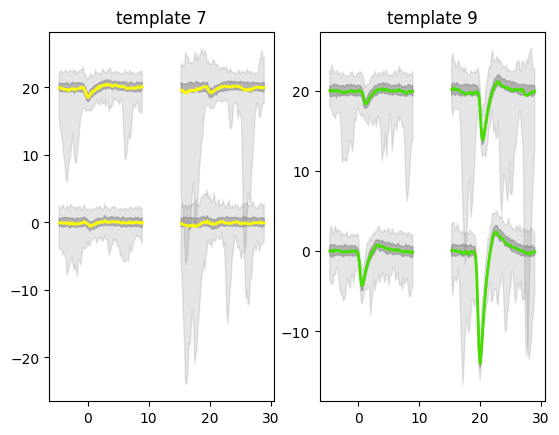

In [17]:
sw.plot_unit_templates(sorting_analyzer, unit_ids=[7,9])

Nice - we see that unit 9 does look a lot more spikey than unit 7. You might think that unit
7 is a real unit. If so, this model isn't good for you.

## Assess the model performance

To assess the performance of the model relative to human labels, we can load or generate some
human labels, and plot a confusion matrix of predicted vs human labels for all clusters. Here
we'll be a conservative human, who has labelled several units with small amplitudes as 'bad'.



In [18]:
labels

,prediction,probability
0,good,0.813516
1,good,0.937453
2,good,0.925897
3,good,0.774516
4,good,0.813516
5,good,0.615849
6,good,0.867973
7,bad,0.635440
8,good,0.858960
9,good,0.916929


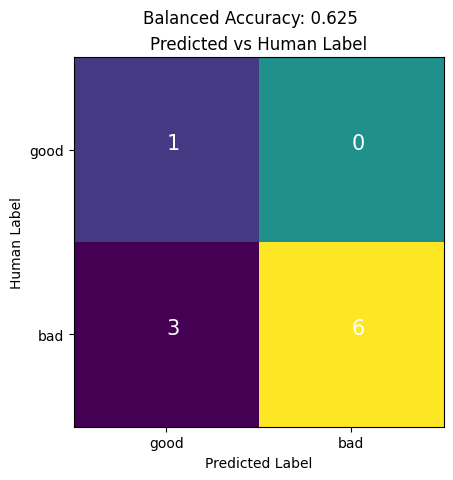

In [19]:
human_labels = ['bad', 'good', 'good', 'bad', 'good', 'bad', 'good', 'bad', 'good', 'good']

# Note: if you labelled using phy, you can load the labels using:
# human_labels = sorting_analyzer.sorting.get_property('quality')

from sklearn.metrics import confusion_matrix, balanced_accuracy_score

label_conversion = model_info['label_conversion']
predictions = [labels.iloc[a, 0] for a in range(10)]

conf_matrix = confusion_matrix(human_labels, predictions)

# Calculate balanced accuracy for the confusion matrix
balanced_accuracy = balanced_accuracy_score(human_labels, predictions)

plt.imshow(conf_matrix)
for (index, value) in np.ndenumerate(conf_matrix):
    plt.annotate( str(value), xy=index, color="white", fontsize="15")
plt.xlabel('Predicted Label')
plt.ylabel('Human Label')
plt.xticks(ticks = [0, 1], labels = list(label_conversion.values()))
plt.yticks(ticks = [0, 1], labels = list(label_conversion.values()))
plt.title('Predicted vs Human Label')
plt.suptitle(f"Balanced Accuracy: {balanced_accuracy}")
plt.show()

Here, there are several false positives (if we consider the human labels to be "the truth").

Next, we can also see how the model's confidence relates to the probability that the model
label matches the human label

This could be used to set a threshold above which you accept the model's classification,
and only manually curate those which it is less sure of.



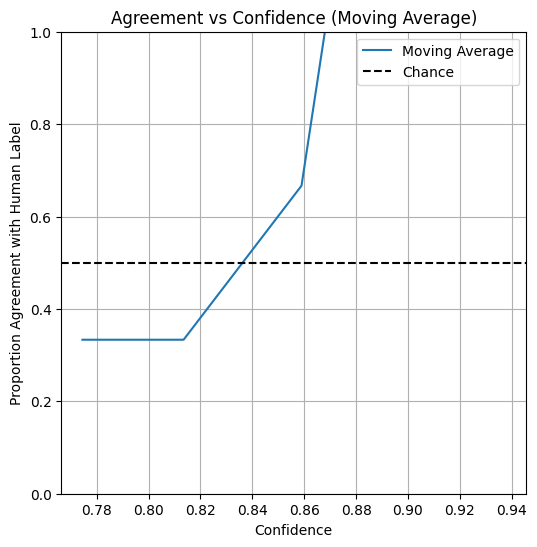

In [20]:
def calculate_moving_avg(label_df, confidence_label, window_size):

    label_df[f'{confidence_label}_decile'] = pd.cut(label_df[confidence_label], 10, labels=False, duplicates='drop')
    # Group by decile and calculate the proportion of correct labels (agreement)
    p_label_grouped = label_df.groupby(f'{confidence_label}_decile')['model_x_human_agreement'].mean()
    # Convert decile to range 0-1
    p_label_grouped.index = p_label_grouped.index / 10
    # Sort the DataFrame by confidence scores
    label_df_sorted = label_df.sort_values(by=confidence_label)

    p_label_moving_avg = label_df_sorted['model_x_human_agreement'].rolling(window=window_size).mean()

    return label_df_sorted[confidence_label], p_label_moving_avg

confidences = sorting_analyzer.sorting.get_property('classifier_probability')

# Make dataframe of human label, model label, and confidence
label_df = pd.DataFrame(data = {
    'human_label': human_labels,
    'decoder_label': predictions,
    'confidence': confidences},
    index = sorting_analyzer.sorting.get_unit_ids())

# Calculate the proportion of agreed labels by confidence decile
label_df['model_x_human_agreement'] = label_df['human_label'] == label_df['decoder_label']

p_agreement_sorted, p_agreement_moving_avg = calculate_moving_avg(label_df, 'confidence', 3)

# Plot the moving average of agreement
plt.figure(figsize=(6, 6))
plt.plot(p_agreement_sorted, p_agreement_moving_avg, label = 'Moving Average')
plt.axhline(y=1/len(np.unique(predictions)), color='black', linestyle='--', label='Chance')
plt.xlabel('Confidence'); #plt.xlim(0.5, 1)
plt.ylabel('Proportion Agreement with Human Label'); plt.ylim(0, 1)
plt.title('Agreement vs Confidence (Moving Average)')
plt.legend(); plt.grid(True); plt.show()